In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from datetime import datetime, timedelta
from metpy.units import units
from metpy.calc import wind_components

In [2]:
def datetime_range(start, end, delta):
    current = start
    while current <= end:
        yield current
        current += delta

def csv_list(year, month, date):
    dts = [f'{dt.hour}-{dt.minute}.csv' for dt in 
           datetime_range(datetime(year, month, date, 0), datetime(year, month, date, 23, 59), timedelta(minutes=10))]
    return dts

def calc_u_v(df, ob_point):
    wind_dir = df['WD1']
    wind_speed = df['WS1']
    wind_u_v = wind_components(wind_speed * units('m/s'), wind_dir * units.deg)
    return [ob_point, round(wind_u_v[0].magnitude, 5), round(wind_u_v[1].magnitude, 5)] # (index, u wind, v wind) u: X (East-West) v: Y(North-South)

csv_files = csv_list(2020, 1, 1)

over5_rain_csvnames = {}
rain = []
root_path = '../../../data/one_day_data/2020/'
monthes = [i for i in range(4, 11)]
cols = ['hour-rain']
for month in monthes:
    if month < 10:
        month = '0'+str(month)
    else:
        month = str(month)
    for date in os.listdir(root_path + month):
        for i in range(0, 133, 12):
            max_rain = 0
            for csv_file in csv_files[i:i+12]:
                one_df = pd.read_csv(root_path + f'{month}/{date}/{csv_file}', index_col=0) # index: observation name
                one_df.index.names = ['ob_point']
                wind_df = pd.DataFrame( [calc_u_v(one_df.loc[i, :], i) for i in one_df.index], columns=['ob_point', 'u_wind', 'v_wind'])
                wind_df = wind_df.set_index('ob_point')
                one_df = one_df.merge(wind_df, how='left', on='ob_point')
                if one_df['hour-rain'].max() > max_rain:
                    max_rain = one_df['hour-rain'].max()
            if max_rain > 5:
                if not date in over5_rain_csvnames:
                    over5_rain_csvnames[date] = []
                over5_rain_csvnames[date].append(csv_files[i:i+12])
                
            rain.append(max_rain)
rain_df = pd.DataFrame({'rain':rain })

In [3]:
train_data_list = []
cols = ['date', 'start', 'end']
count = 0
for key in over5_rain_csvnames.keys():
    files = over5_rain_csvnames[key]
    start = files[0][0]
    end = files[-1][-1]
    train_data_list.append([key, start, end])
df = pd.DataFrame(train_data_list, columns=cols)
df.head()
df.to_csv('train_data_list.csv')

15.714285714285714 % rain dataset in all dataset


,rain
count,2448.000000
mean,3.925858
std,10.362460
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,88.000000


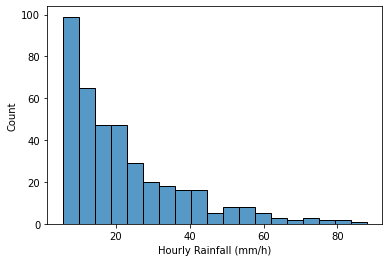

In [4]:
rain_df_over1 = rain_df.loc[rain_df['rain'] > 5]

fig, ax = plt.subplots()
sns.histplot(rain_df_over1, bins=19, ax=ax)
ax.set_xlabel('Hourly Rainfall (mm/h)')
ax.get_legend().remove()
plt.savefig('rain_histplot.png')
print((len(rain_df_over1)/(30*12*7))*100, '% rain dataset in all dataset')
rain_df.describe()

In [5]:
data = {}
for date in [*over5_rain_csvnames]:
    if not date in data:
        data[date] = []
    for csv_names in over5_rain_csvnames[date]:
        df = pd.DataFrame()
        month = date.split('-')[1]
        max_rain = 0
        for csv_name in csv_names:
            one_df = pd.read_csv(root_path + f'{month}/{date}/{csv_name}', index_col=0)
            if one_df['hour-rain'].max() > max_rain:
                max_rain = one_df['hour-rain'].max()
            for ob_point in one_df.index:
                ob = ob_point.split('_')[0]
                for col in one_df.columns:
                    df.loc[csv_name, f'{col}-{ob}'] = one_df.loc[ob_point, col]
        data[date].append(df)
        print(date, max_rain)

2020-04-17 11.0
2020-04-17 16.0
2020-04-18 23.0
2020-04-18 45.5
2020-04-09 8.5
2020-04-09 15.5
2020-04-09 15.5
2020-04-07 6.0
2020-04-13 14.5
2020-04-13 24.0
2020-04-16 31.0
2020-04-10 6.0
2020-04-10 9.0
2020-04-29 15.5
2020-04-29 18.0
2020-04-26 8.0
2020-04-26 13.0
2020-04-27 6.0
2020-04-27 20.5
2020-04-12 8.5
2020-04-12 8.5
2020-04-22 12.0
2020-04-22 16.0
2020-05-18 25.5
2020-05-18 7.0
2020-05-15 9.0
2020-05-15 9.0
2020-05-15 15.0
2020-05-15 35.0
2020-05-15 45.5
2020-05-15 12.5
2020-05-14 16.5
2020-05-14 17.0
2020-05-14 7.0
2020-05-14 7.0
2020-05-10 20.5
2020-05-10 34.5
2020-05-10 9.5
2020-05-23 8.5
2020-05-23 20.5
2020-05-23 16.5
2020-05-23 16.5
2020-05-06 36.0
2020-05-06 59.0
2020-05-06 25.5
2020-05-16 11.0
2020-05-16 16.5
2020-05-12 21.0
2020-05-12 8.5
2020-05-26 31.0
2020-05-26 26.5
2020-05-19 24.5
2020-05-19 22.5
2020-05-19 5.5
2020-05-19 5.5
2020-05-25 45.5
2020-05-25 29.0
2020-05-27 36.0
2020-05-27 33.5
2020-05-27 15.5
2020-05-27 19.0
2020-05-21 33.0
2020-05-21 33.0
2020-05-28

In [6]:
df = data['2020-08-01'][1]
hour_rain_cols = [col for col in df.columns if 'rain' in col]
for col in hour_rain_cols:
    if df[col].max() > 50:
        print(col)
df[hour_rain_cols].describe()

hour-rain-Bayanan-ES
hour-rain-LP-DrFelimon


,hour-rain-Vlz-Bagbaguin,hour-rain-NagNayon,hour-rain-Sinegue,hour-rain-DLSAU,hour-rain-ASTI,hour-rain-MM-SanAndres,hour-rain-Vlz-DRRMO,hour-rain-UniManila,hour-rain-TUP-Taguig,hour-rain-MM-Catmon,...,hour-rain-MM-Libertad,hour-rain-LP-DrFelimon,hour-rain-CAAP,hour-rain-GH-Subdiv,hour-rain-C3Bldg,hour-rain-MM-Balut,hour-rain-Xavier-Sch,hour-rain-DOST,hour-rain-Vlz-Punturin,hour-rain-QC-SciHS
count,12.000000,12.000000,12.000000,12.0,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,...,12.00000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,2.125000,3.666667,22.541667,0.0,0.041667,2.458333,4.833333,9.750000,7.041667,3.166667,...,5.50000,45.458333,6.000000,26.458333,0.333333,5.833333,0.291667,9.666667,11.375000,2.250000
std,2.035202,3.485902,14.075217,0.0,0.144338,1.839693,4.468747,6.569558,5.948485,2.452581,...,3.98862,33.469429,4.322247,17.181462,1.154701,4.787927,0.257464,8.917127,10.656038,2.168996
min,0.000000,0.000000,6.500000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,10.125000,0.0,0.000000,0.500000,0.750000,4.625000,0.750000,0.875000,...,2.00000,16.500000,3.125000,16.750000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,2.250000,3.750000,16.750000,0.0,0.000000,2.500000,5.000000,8.750000,7.500000,3.250000,...,5.25000,46.000000,6.500000,28.750000,0.000000,5.750000,0.500000,10.000000,11.500000,2.250000
75%,4.000000,7.125000,38.125000,0.0,0.000000,4.125000,9.000000,16.250000,12.625000,5.500000,...,9.62500,76.250000,8.625000,39.750000,0.000000,10.625000,0.500000,17.125000,22.500000,4.500000
max,4.500000,7.500000,39.000000,0.0,0.500000,4.500000,9.500000,17.500000,15.000000,6.000000,...,10.00000,88.000000,14.500000,49.500000,4.000000,11.000000,0.500000,21.000000,23.000000,4.500000


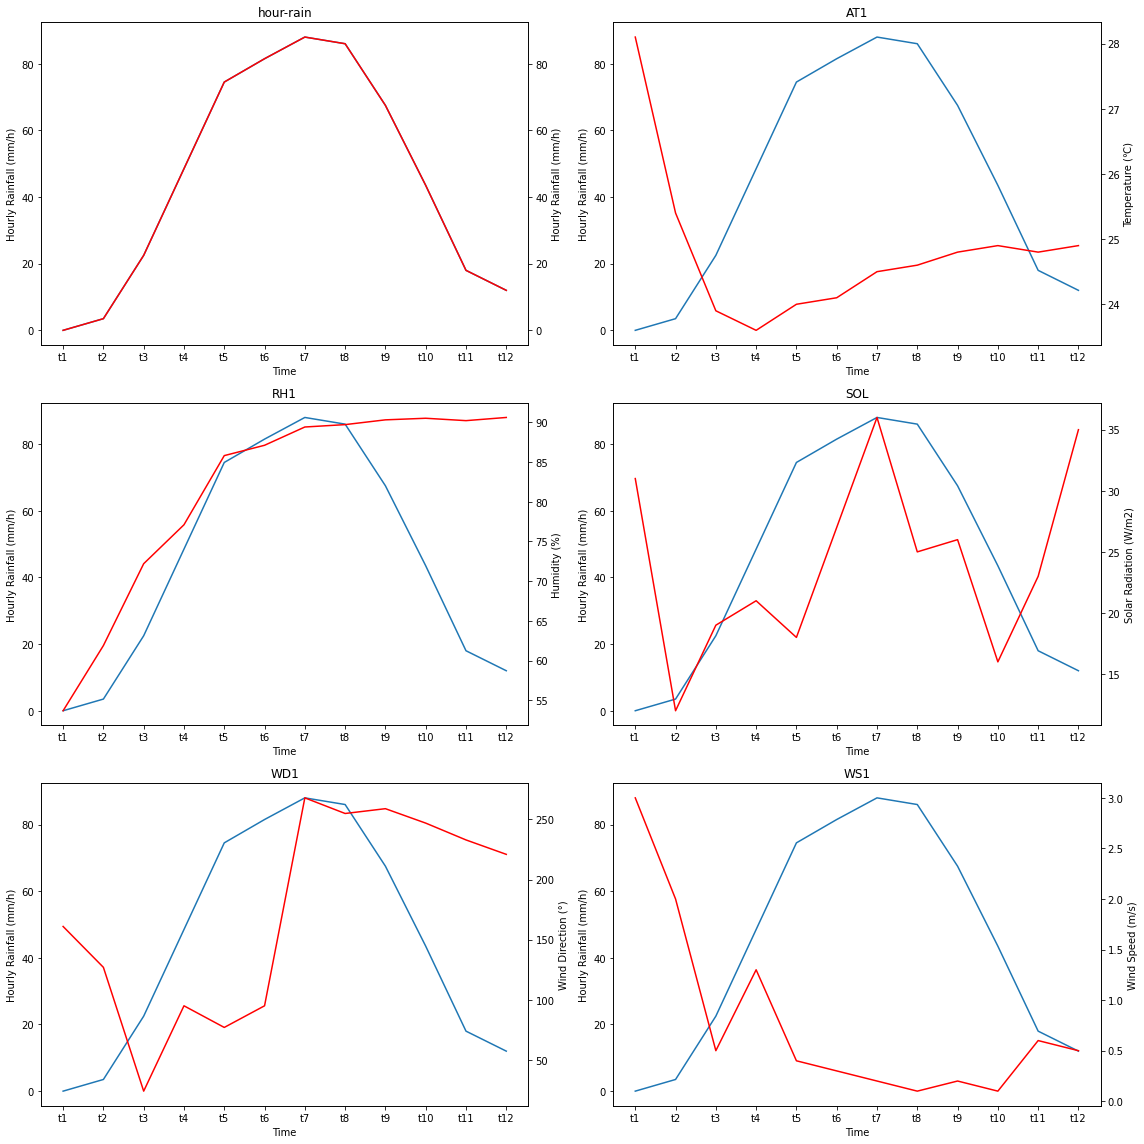

In [7]:
fig,axs = plt.subplots(3, 2, figsize=(16, 16))
axs = axs.flatten()
cols = ['hour-rain', 'AT1', 'RH1', 'SOL', 'WD1', 'WS1']
cols_name = ['Hourly Rainfall', 'Temperature', 'Humidity', 'Solar Radiation', 'Wind Direction', 'Wind Speed']
units = ['mm/h', '℃', '%', 'W/m2', '°', 'm/s']
for i in range(6):
    ax = axs[i]
    ax2 = ax.twinx()
    sns.lineplot(data=df, x=['t'+str(i+1) for i in range(12)], y='hour-rain-LP-DrFelimon', ax=ax)
    sns.lineplot(data=df, x=['t'+str(i+1) for i in range(12)], y=f'{cols[i]}-LP-DrFelimon', ax=ax2, color='r')
    ax.set_title(cols[i])
    ax.set_ylabel('Hourly Rainfall (mm/h)')
    ax2.set_ylabel(f'{cols_name[i]} ({units[i]})')
    ax.set_xlabel('Time')

fig.savefig(f'./cases/case1.png')
    
plt.tight_layout()

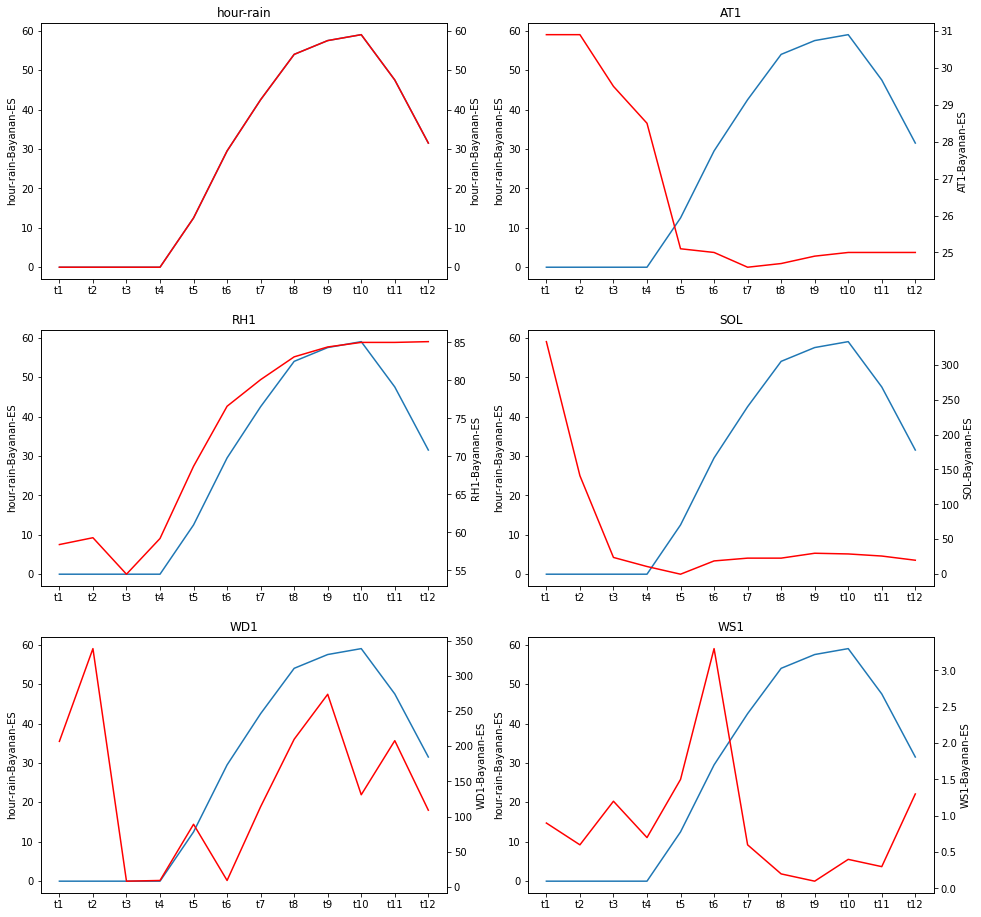

In [8]:
fig,axs = plt.subplots(3, 2, figsize=(16, 16))
axs = axs.flatten()
cols = ['hour-rain', 'AT1', 'RH1', 'SOL', 'WD1', 'WS1']
for i in range(6):
    ax = axs[i]
    ax2 = ax.twinx()
    sns.lineplot(data=df, x=['t'+str(i+1) for i in range(12)], y='hour-rain-Bayanan-ES', ax=ax)
    sns.lineplot(data=df, x=['t'+str(i+1) for i in range(12)], y=f'{cols[i]}-Bayanan-ES', ax=ax2, color='r')
    ax.set_title(cols[i])
fig.savefig(f'./cases/case2.png')

In [24]:
cols = ['10min_change_of_Hourly-Rainfall', '10min_change_of_AT1', '10min_change_of_RH1', '10min_change_of_SOL',
        '10min_change_of_WD1', '10min_change_of_WS1', '10min_change_of_U-wind', '10min_change_of_V-wind']
log_data = dict((q, []) for q in cols)

def log(item_list):
    return np.log(item_list + 1).diff().dropna().values.tolist()

def pct_change(item_list: pd.Series):
    item_list += 1
    return item_list.pct_change().dropna().values.tolist()

def sbt_change(item_list: pd.Series):
    return item_list.diff().dropna().values.tolist()

csv_files = csv_list(2020, 1, 1)

for date in [*over5_rain_csvnames]:
    if not date in data:
        data[date] = []
    for csv_names in over5_rain_csvnames[date]:
        df = pd.DataFrame()
        month = date.split('-')[1]
        start, end = csv_files.index(csv_names[0]), csv_files.index(csv_names[-1])
        start = start - 12 if start > 12 else 0
        end = end + 12 if end < 132 else 143
        for csv_name in csv_files[start:end]:
            one_df = pd.read_csv(root_path + f'{month}/{date}/{csv_name}', index_col=0)
            one_df.index.names = ['ob_point']
            wind_df = pd.DataFrame( [calc_u_v(one_df.loc[i, :], i) for i in one_df.index], columns=['ob_point', 'u_wind', 'v_wind'])
            wind_df = wind_df.set_index('ob_point')
            for c in wind_df.columns:
                wind_df[c] = np.where(wind_df[c] > 10, 10, wind_df[c])
                wind_df[c] = np.where(wind_df[c] < -10, -10, wind_df[c])
                wind_df[c] = wind_df[c] + 10
            one_df = one_df.merge(wind_df, how='left', on='ob_point')
            
            for ob_point in one_df.index:
                ob = ob_point.split('_')[0]
                for col in one_df.columns:
                    df.loc[csv_name, f'{col}-{ob}'] = one_df.loc[ob_point, col]
                    
        # calculate logarithmic value of the data
        col_name = '10min_change_of_'
        for col in df.columns:
            if 'rain' in col:
                log_data[col_name + 'Hourly-Rainfall'] += sbt_change(df[col])

            elif 'AT1' in col:
                log_data[col_name + 'AT1'] += sbt_change(df[col])

            elif 'RH1' in col:
                log_data[col_name + 'RH1'] += sbt_change(df[col])
                
            elif 'SOL' in col:
                log_data[col_name + 'SOL'] += sbt_change(df[col])
                
            elif 'u_wind' in col:
                log_data[col_name + 'U-wind'] += sbt_change(df[col])
            
            elif 'v_wind' in col:
                log_data[col_name + 'V-wind'] += sbt_change(df[col])

            elif 'WD1' in col:
                log_data[col_name + 'WD1'] += sbt_change(df[col])

            elif 'WS1' in col:
                log_data[col_name + 'WS1'] += sbt_change(df[col])
                

log_df = pd.DataFrame(log_data)
log_df.head()

,10min_change_of_Hourly-Rainfall,10min_change_of_AT1,10min_change_of_RH1,10min_change_of_SOL,10min_change_of_WD1,10min_change_of_WS1,10min_change_of_U-wind,10min_change_of_V-wind
0,0.0,-0.2,1.3,161.0,5.0,-0.1,-0.09848,-0.03486
1,0.0,1.8,-0.1,746.0,-60.0,-0.1,-0.20000,0.17321
2,0.0,0.9,-2.4,-517.0,72.0,0.1,0.19344,-0.23558
3,0.0,-0.6,-0.5,-103.0,-17.0,-0.1,-0.09420,0.07980
4,0.0,0.2,-0.6,335.0,8.0,0.1,0.10035,-0.03313


In [ ]:
for key in log_data.keys():
    print(key, len(log_data[key]))

In [26]:
log_df.describe()

,10min_change_of_Hourly-Rainfall,10min_change_of_AT1,10min_change_of_RH1,10min_change_of_SOL,10min_change_of_WD1,10min_change_of_WS1,10min_change_of_U-wind,10min_change_of_V-wind
count,426894.000000,426894.000000,426894.000000,426894.000000,426894.000000,426894.000000,426894.000000,426894.000000
mean,0.003903,-0.086086,0.328768,-7.119202,-0.593266,-0.005322,-0.004159,-0.002671
std,1.418796,0.520059,1.792549,117.154185,106.864749,0.657870,0.606634,0.641961
min,-29.000000,-8.500073,-41.300000,-1215.000000,-360.000000,-44.100000,-16.749310,-20.000000
25%,0.000000,-0.200000,-0.400000,-9.000000,-29.000000,-0.200000,-0.229030,-0.241740
50%,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.100000,0.900000,0.000000,28.000000,0.200000,0.221608,0.238660
max,29.000000,8.600073,57.800000,1098.000000,360.000000,43.900000,15.671240,19.257190


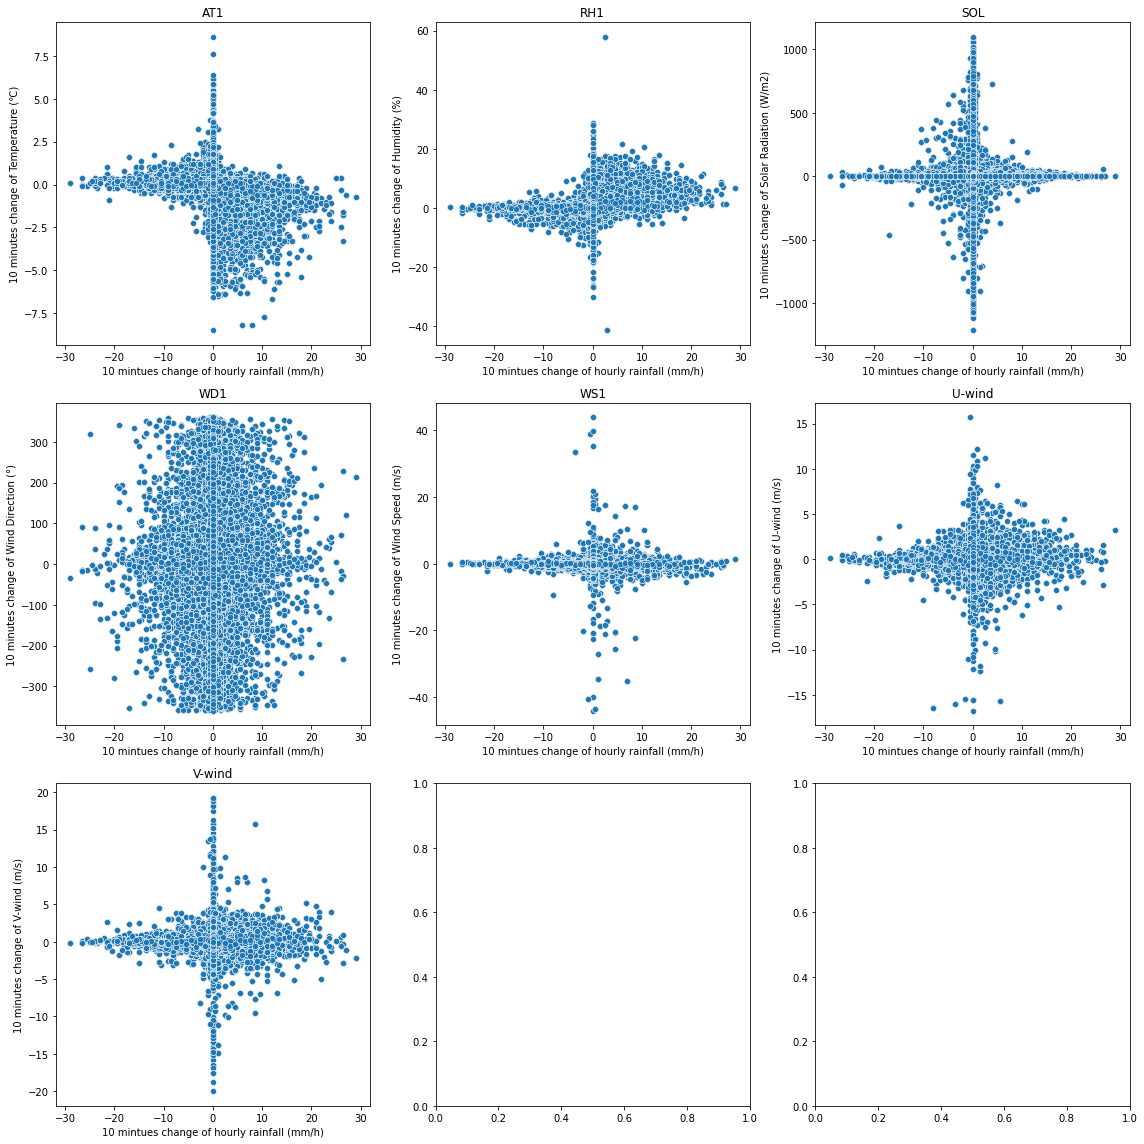

In [30]:
log_df['hue'] = np.where(log_df['10min_change_of_Hourly-Rainfall'] > 0, 1, -1)
fig, axs = plt.subplots(3, 3, figsize=(16, 16))
axs = axs.flatten()
cols = ['AT1', 'RH1', 'SOL', 'WD1', 'WS1', 'U-wind', 'V-wind']
cols_name = ['Temperature (℃)', 'Humidity (%)', 'Solar Radiation (W/m2)', 'Wind Direction (°)', 'Wind Speed (m/s)', 'U-wind (m/s)', 'V-wind (m/s)']


for i in range(len(cols)):
    ax = axs[i]
    sns.scatterplot(data=log_df, x="10min_change_of_Hourly-Rainfall", y=f'10min_change_of_{cols[i]}', ax=ax, palette="tab10")
    ax.set_xlabel('10 mintues change of hourly rainfall (mm/h)')
    ax.set_ylabel(f'10 minutes change of {cols_name[i]}')
    ax.set_title(cols[i])
plt.tight_layout()
fig.savefig('percent_change.png')

In [ ]:
log_df['hue'] = np.where(log_df['log_rain'] > 0, 1, -1)
fig, axs = plt.subplots(2, 3, figsize=(16, 16))
axs = axs.flatten()
cols = ['log_AT1', 'log_RH1', 'log_SOL', 'log_WD1', 'log_WS1']
for i in range(len(cols)):
    ax = axs[i]
    sns.histplot(data=log_df.loc[log_df[cols[i]] != 0], x=cols[i], hue='hue', ax=ax)
    ax.set_title(cols[i])
plt.tight_layout()